In [1]:
# Now you can import the Deck class
import sys
sys.path.append('../src')

from montecarlo import MonteCarlo
from trueskill_dhumbal import TrueskillDhumbal
from player import Player, DiscardBiggestStrategy, MinimizeCardNumberStrategy

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from trueskill import Rating, rate, setup, TrueSkill

In [2]:
VERBOSE = False # setting to tru allows more debugging, but slows down code a lot

In [3]:
# Choose number of players and their strategy
# DiscardBiggestStrategy is a dumb strategy to only get rid of the highest card and draw from the graveyard if card value is less than threshold. Otherwise draw from the deck

# MinimizeCardNumberStrategy is a more advanced strategy that also aims to minimize the number of cards in hand, by "pooling" - actively trying to pair up cards.
# If graveyard matches the card in hand, it will discard other biggest card and draw from the graveyard (trying to pool) if card value that is being paired is not smaller than try_to_pool_threshold.
# MinimizeCardNumberStrategy draws from the graveyard if card value is less than threshold. Otherwise draw from the deck

players = [
    # Player('Player 1', DiscardBiggestStrategy(dhumbal_threshold=5, draw_graveyard_threshold=5), verbose=verbose), 
    # Player('Player 2', DiscardBiggestStrategy(dhumbal_threshold=5, draw_graveyard_threshold=5), verbose=verbose),
    Player('Player 1', MinimizeCardNumberStrategy(dhumbal_threshold=5, draw_graveyard_threshold=8, try_to_pool_threshold=8), verbose=VERBOSE), # bad player, doesnt try to pair up cards < 8. Also draws from graveyard if card value in graveyard is < 8
    Player('Player 2', MinimizeCardNumberStrategy(dhumbal_threshold=2, draw_graveyard_threshold=5, try_to_pool_threshold=3), verbose=VERBOSE), # passive player, only calls dhumbal if value in hand <= 2
    Player('Player 3', MinimizeCardNumberStrategy(dhumbal_threshold=5, draw_graveyard_threshold=5, try_to_pool_threshold=3), verbose=VERBOSE),
    Player('Player 4', MinimizeCardNumberStrategy(dhumbal_threshold=5, draw_graveyard_threshold=5, try_to_pool_threshold=3), verbose=VERBOSE),
    Player('Player 5', MinimizeCardNumberStrategy(dhumbal_threshold=4, draw_graveyard_threshold=4, try_to_pool_threshold=2), verbose=VERBOSE), 
    ]

In [4]:
GAMES_TO_SIMULATE = 10000
mc = MonteCarlo(players, GAMES_TO_SIMULATE, verbose=VERBOSE)
mc.run_simulation()
mc.analyze_results()

## Occupying a certain place
frequency of each player to occupy a certain place

In [5]:
print(mc.player_position_probabilities()) # frequency of occupying each position by a player

OrderedDict([('Player 1', {1: 0.1583, 2: 0.1792, 3: 0.1885, 4: 0.2185, 5: 0.2555}), ('Player 2', {1: 0.0887, 2: 0.2092, 3: 0.2512, 4: 0.2422, 5: 0.2087}), ('Player 3', {1: 0.277, 2: 0.1949, 3: 0.18, 4: 0.1693, 5: 0.1788}), ('Player 4', {1: 0.2756, 2: 0.2008, 3: 0.1775, 4: 0.167, 5: 0.1791}), ('Player 5', {1: 0.2004, 2: 0.2159, 3: 0.2028, 4: 0.203, 5: 0.1779})])


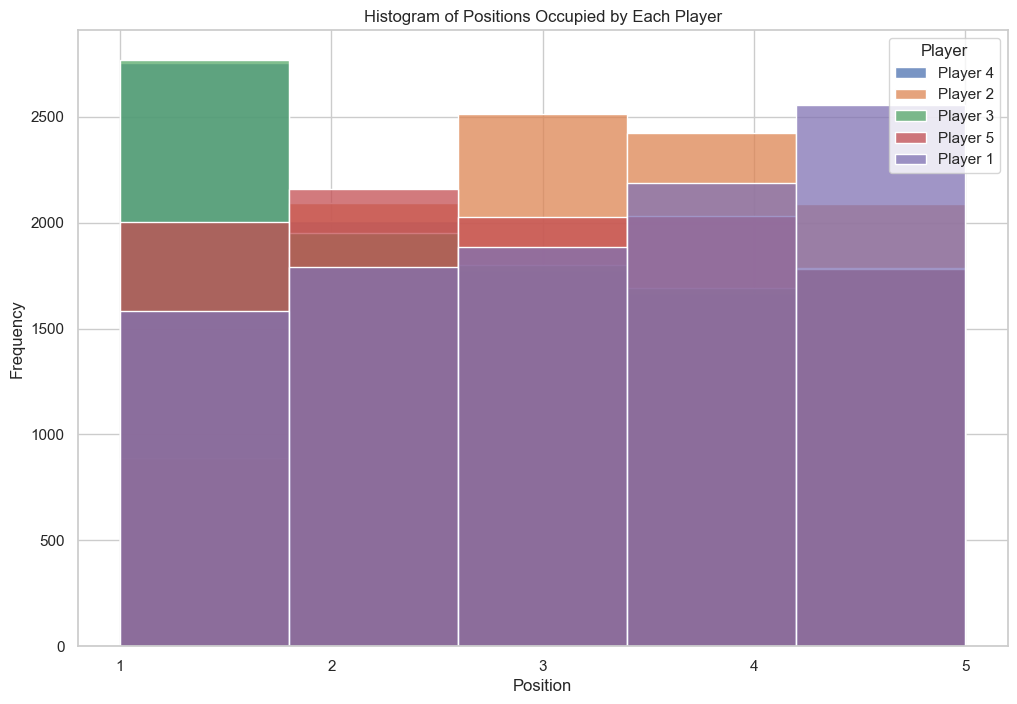

In [6]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

# Plot the histogram for each player's positions
for player_name, stats in mc.player_stats.items():
    sns.histplot(stats['positions'], label=player_name, bins=len(set(stats['positions'])), kde=False, stat="count")

plt.title('Histogram of Positions Occupied by Each Player')
plt.xlabel('Position')
plt.ylabel('Frequency')
plt.legend(title='Player')
plt.xticks(range(1, len(mc.player_stats) + 1))  # Assuming the number of positions is equal to the number of players
plt.show()


### Plot of distribution of number of points scored in each round by player

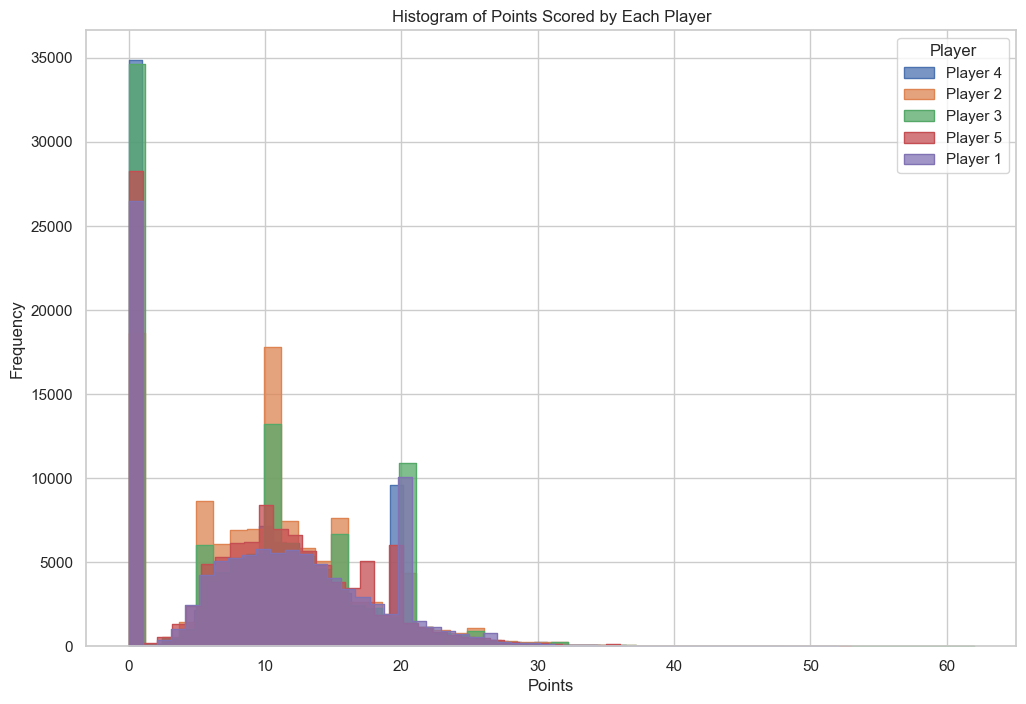

In [7]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

# Plot the histogram for each player's scores
for player, stats in mc.player_stats.items():
    sns.histplot(stats['scores'], kde=False, label=player, bins=50, element='step')

plt.title('Histogram of Points Scored by Each Player')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.legend(title='Player')
plt.show()


# TrueSkill
Initialize trueskill object

In [9]:
ts = TrueskillDhumbal(mc, players, 
                      mu=1300, sigma=300, beta=4000, tau=1, draw_probability=0,
                      sigma_ratio=0.75) # parameters for TrueSkill model

In [10]:
NUMBER_OF_GAMES = 50 # choose a number of games to analyze for TrueSkill within the Monte Carlo simulation

## Bootstrap TrueSkill simulation

- Choose function to use: either assigning rank per each round, or per each game
- Choose a window size of interest in games (e.g. maybe want to look at 20 games)
- Choose how many runs (batches) you want to do. window * batches cannot exceed number of Montecarlo simulations that was done before 

In [20]:
BATCHES = 200 # max is GAMES_TO_SIMULATE / NUMBER_OF_GAMES
ts.run_simulation(NUMBER_OF_GAMES, BATCHES, ts.ratings_round_outcome) # runs based on rounds

# ts.run_simulation(NUMBER_OF_GAMES, BATCHES, ts.ratings_round_outcome) # runs based on games

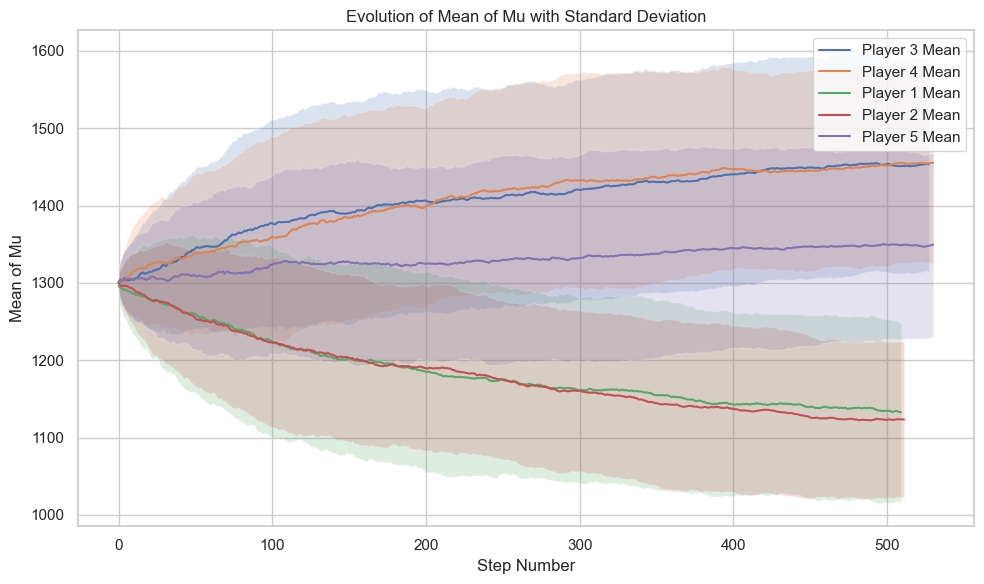

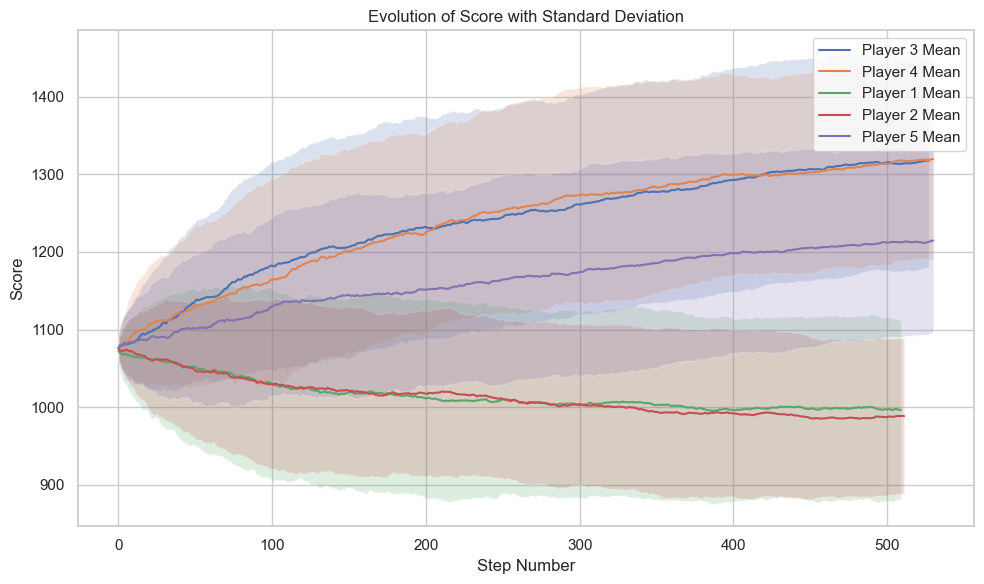

In [21]:
ts.plot_ratings_windows()
ts.plot_ratings_windows(plot_score=True)

## Study for taking one specific scenario of games, and seeing real TrueSkill parameters change

Example: process based on game position occupied

Plot shows actual True skill mu and sigma values change across time

Real TrueSkill value is mu-3*sigma, but we might need to do mu - 0.75sigma

######## Rating details below #############

Player 3 trueskill.Rating(mu=1293.915, sigma=276.027)
Player 4 trueskill.Rating(mu=1420.450, sigma=276.488)
Player 1 trueskill.Rating(mu=1033.259, sigma=277.190)
Player 2 trueskill.Rating(mu=1224.051, sigma=275.865)
Player 5 trueskill.Rating(mu=1527.095, sigma=275.946)

######## Score details below ##############

Player 3 1086.894388143663
Player 4 1213.0842411668832
Player 1 825.3664489928001
Player 2 1017.1524159735513
Player 5 1320.1358678433157


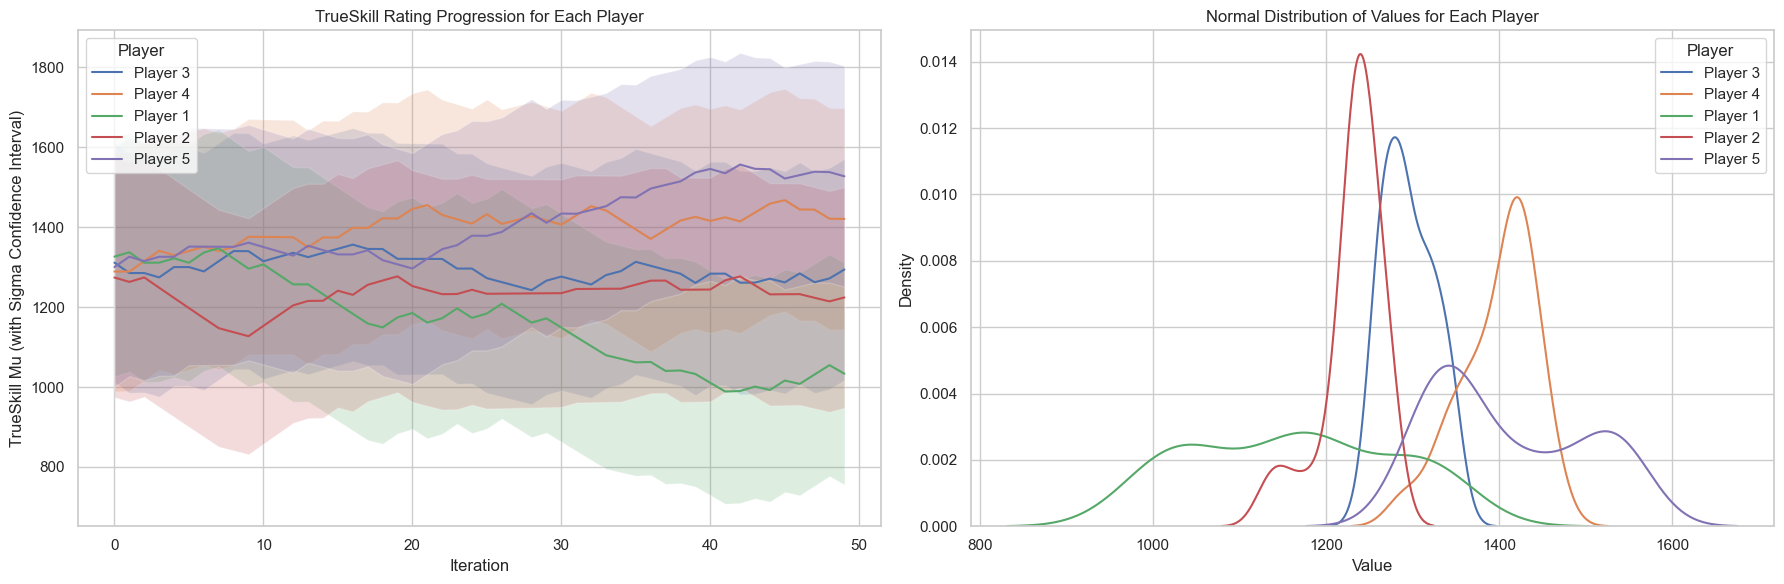

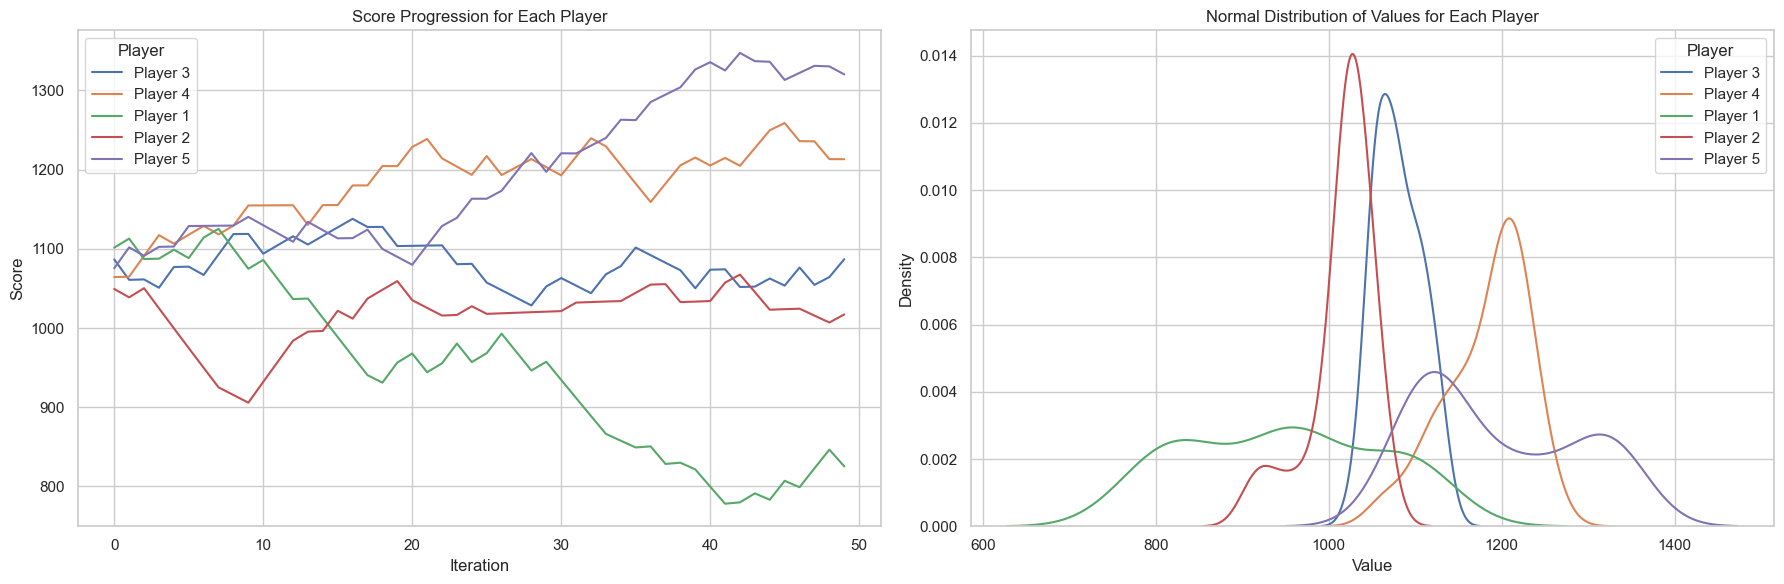

In [22]:
ts.ratings_game_outcome(NUMBER_OF_GAMES)
print("######## Rating details below #############", end="\n\n")
ts.get_all_player_ratings()
print("\n######## Score details below ##############", end="\n\n")
ts.get_all_player_score()
ts.plot_ratings()
ts.plot_ratings(plot_score=True)

######## Rating details below #############

Player 3 trueskill.Rating(mu=1323.676, sigma=176.241)
Player 4 trueskill.Rating(mu=1445.768, sigma=175.980)
Player 1 trueskill.Rating(mu=1026.832, sigma=179.694)
Player 2 trueskill.Rating(mu=1242.846, sigma=175.008)
Player 5 trueskill.Rating(mu=1467.481, sigma=174.157)

######## Score details below ##############

Player 3 1191.495696760697
Player 4 1313.7828915689815
Player 1 892.0617044420624
Player 2 1111.5894698782213
Player 5 1336.8630712955032


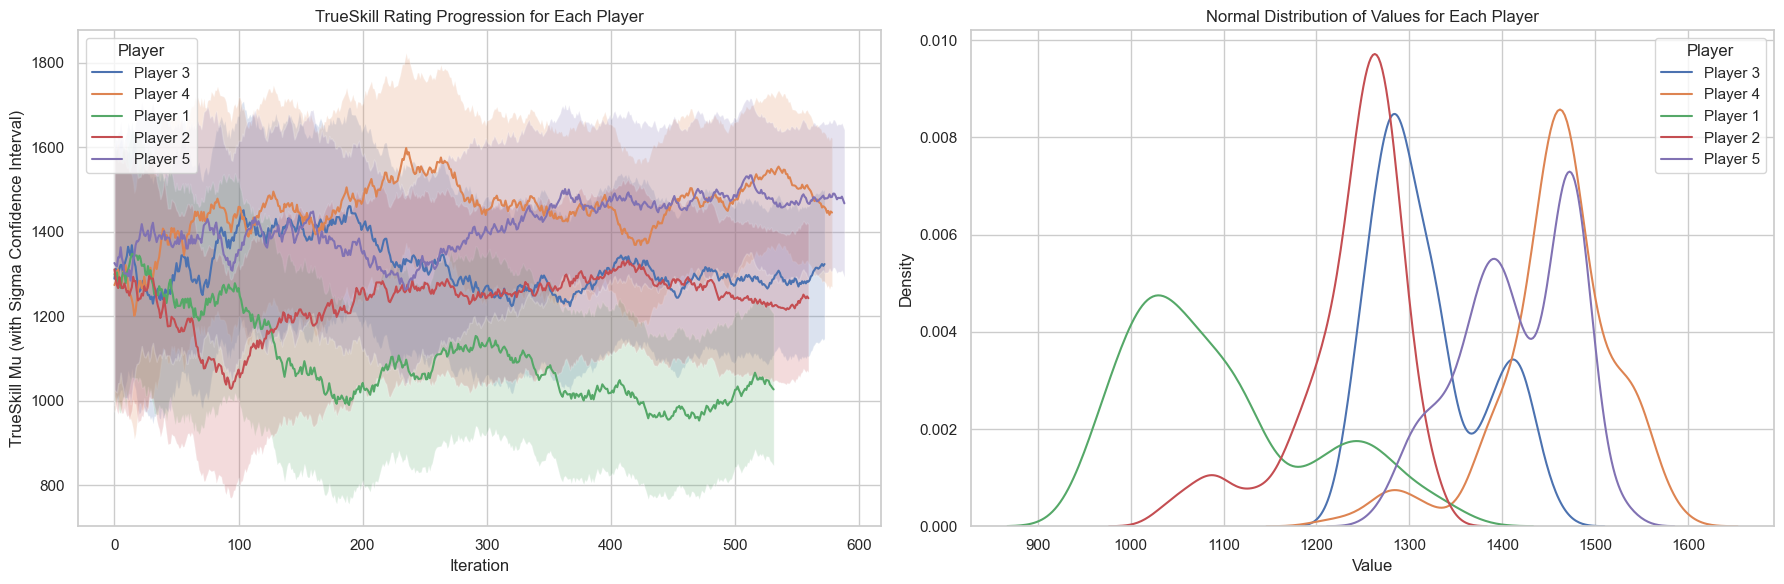

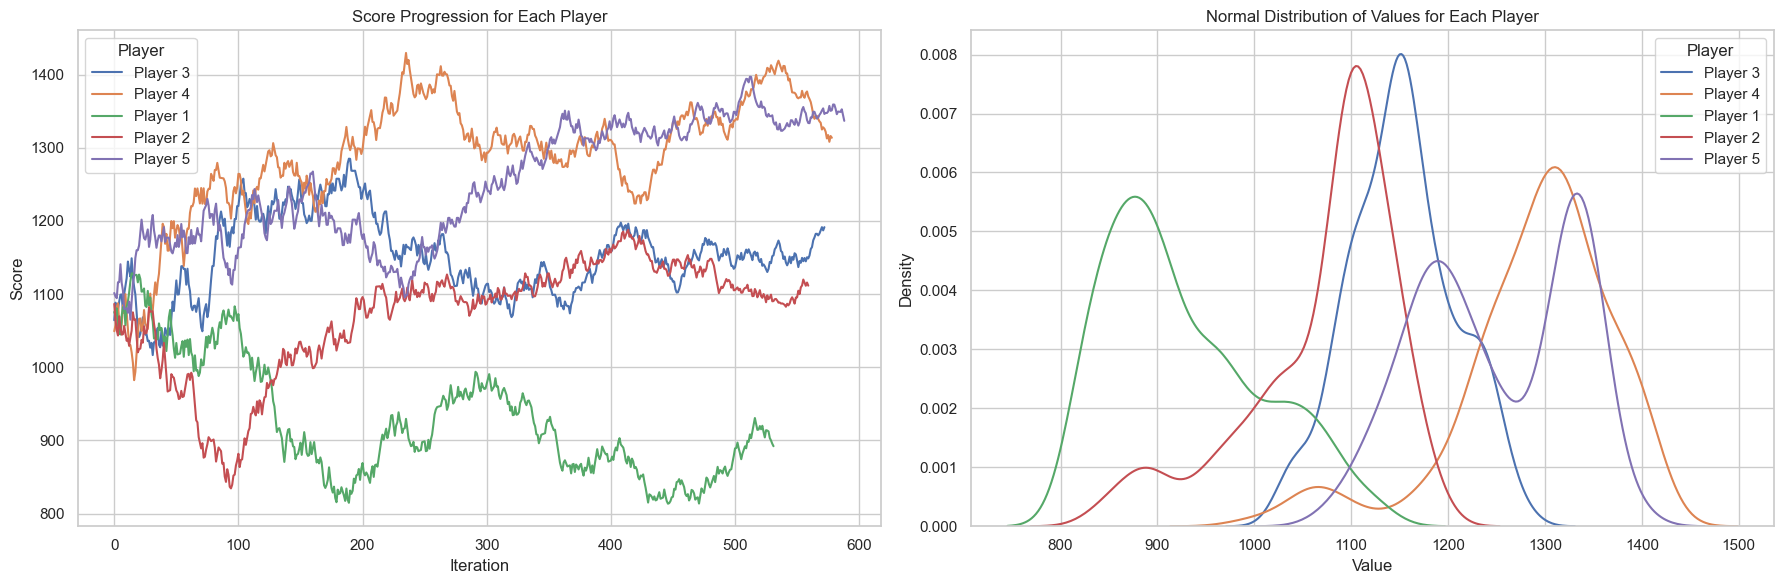

In [23]:
ts.ratings_round_outcome(NUMBER_OF_GAMES)
print("######## Rating details below #############", end="\n\n")
ts.get_all_player_ratings()
print("\n######## Score details below ##############", end="\n\n")
ts.get_all_player_score()
ts.plot_ratings()
ts.plot_ratings(plot_score=True)

# Playground
some experimental code below

In [24]:
# ts.win_probability([ts.player_stats['Player 1']['trueskill_rating']], [ts.player_stats['Player 3']['trueskill_rating']])

In [ ]:
# TrueSkill().quality([(ts.player_stats[player.name]['trueskill_rating'],) for player in players]) # outputs draw probability, which is meaningless in Dhumbal